In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt

from textblob import TextBlob
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,f1_score


from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost


In [3]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
df_positive = df[df["sentiment"] == "positive"].sample(5000)
df_negative = df[df["sentiment"] == "negative"].sample(5000)

In [7]:
df = pd.concat([df_positive,df_negative],ignore_index=True).sample(10000)

In [8]:
df.head()

,review,sentiment
4958,First of all I'd like to start by saying it's ...,positive
6672,The only thing that prevented this flick from ...,negative
827,An excellent film for those who simply need to...,positive
1265,This film is a tour de force from Julie Taymor...,positive
8880,At first I was convinced that this was a made-...,negative


In [9]:
df.shape

(10000, 2)

### Data Cleaning

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 4958 to 3740
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB


In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])

In [13]:
df.head()

,review,sentiment
4958,First of all I'd like to start by saying it's ...,1
6672,The only thing that prevented this flick from ...,0
827,An excellent film for those who simply need to...,1
1265,This film is a tour de force from Julie Taymor...,1
8880,At first I was convinced that this was a made-...,0


In [14]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [15]:
df.duplicated().sum()

9

In [16]:
df = df.drop_duplicates(keep="first")

In [17]:
df.duplicated().sum()

0

In [18]:
df.shape

(9991, 2)

# Data Preprocessing

### 1. Lowercase conversion

In [19]:
df["review"] = df["review"].apply(lambda x:x.lower())

In [20]:
df.head()

,review,sentiment
4958,first of all i'd like to start by saying it's ...,1
6672,the only thing that prevented this flick from ...,0
827,an excellent film for those who simply need to...,1
1265,this film is a tour de force from julie taymor...,1
8880,at first i was convinced that this was a made-...,0


### 2. Contraction to Expansion

In [21]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

In [22]:
def contr_to_exp(x):
    
    if type(x) is str:
        for key in contractions.keys():
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

In [23]:
df["review"] = df["review"].apply(contr_to_exp)

In [24]:
df.head()

,review,sentiment
4958,first of all i would like to start by saying i...,1
6672,the only thing that prevented this flick from ...,0
827,an excellent film for those who simply need to...,1
1265,this film is a tour de force from julie taymor...,1
8880,at first i was convinced that this was a made-...,0


### Remove URL

In [25]:
import re

In [26]:
df["urls"] = df["review"].apply(lambda x: re.findall(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', x))

In [27]:
df["urls_count"] = df["urls"].apply(lambda x: len(x))

In [28]:
df[df["urls_count"]>0]

,review,sentiment,urls,urls_count
87,<br /><br />i saw once no man's land (1987) - ...,1,[http://us.imdb.com],1
2118,following directly from where the story left o...,1,[http://www.invocus.net],1
3985,"this, unfortunately, is a little-known film......",1,[http://www.nvogel.com],1
6208,alone in the dark is uwe boll's kick in the nu...,0,"[http://www.cinemablend.com, http://www.cinema...",2
424,sandra bullock paints a believable picture as ...,1,[http://us.imdb.com],1
1609,"the secret of kells is one of the most unique,...",1,[http://theoscarsblog.blogspot.com],1
8109,according to the article at http://blog.ifeng....,0,[http://blog.ifeng.com],1
2611,this film is the greatest ninja film ever made...,1,[http://uk.geocities.com],1
8981,"""little man"", now on dvd, is a wayans brothers...",0,[http://mcmusicnotes.blogspot.com],1
5033,i run a group to stop comedian exploitation an...,0,[http://www.youtube.com],1


In [29]:
df["review"] = df["review"].apply(lambda x:re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', x))

In [30]:
df[df["urls_count"]>0]

,review,sentiment,urls,urls_count
87,<br /><br />i saw once no man's land (1987) - ...,1,[http://us.imdb.com],1
2118,following directly from where the story left o...,1,[http://www.invocus.net],1
3985,"this, unfortunately, is a little-known film......",1,[http://www.nvogel.com],1
6208,alone in the dark is uwe boll's kick in the nu...,0,"[http://www.cinemablend.com, http://www.cinema...",2
424,sandra bullock paints a believable picture as ...,1,[http://us.imdb.com],1
1609,"the secret of kells is one of the most unique,...",1,[http://theoscarsblog.blogspot.com],1
8109,according to the article at /article/2737487.h...,0,[http://blog.ifeng.com],1
2611,this film is the greatest ninja film ever made...,1,[http://uk.geocities.com],1
8981,"""little man"", now on dvd, is a wayans brothers...",0,[http://mcmusicnotes.blogspot.com],1
5033,i run a group to stop comedian exploitation an...,0,[http://www.youtube.com],1


### Removal of HTML tags

In [31]:
def remove_html_tags(html_string):
    # Regular expression pattern to match HTML tags
    pattern = re.compile(r'<.*?>')

    # Remove HTML tags using the pattern
    text = re.sub(pattern, '', html_string)

    return text

In [32]:
df["review"] = df["review"].apply(remove_html_tags)

In [33]:
df.head()

,review,sentiment,urls,urls_count
4958,first of all i would like to start by saying i...,1,[],0
6672,the only thing that prevented this flick from ...,0,[],0
827,an excellent film for those who simply need to...,1,[],0
1265,this film is a tour de force from julie taymor...,1,[],0
8880,at first i was convinced that this was a made-...,0,[],0


### Removal of Email

In [34]:
df["emails"] = df["review"].apply(lambda x: re.findall(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', x))

In [35]:
df.head()

,review,sentiment,urls,urls_count,emails
4958,first of all i would like to start by saying i...,1,[],0,[]
6672,the only thing that prevented this flick from ...,0,[],0,[]
827,an excellent film for those who simply need to...,1,[],0,[]
1265,this film is a tour de force from julie taymor...,1,[],0,[]
8880,at first i was convinced that this was a made-...,0,[],0,[]


In [36]:
df["email_count"] = df["emails"].apply(lambda x:len(x))

In [37]:
df[df["email_count"]>0]

,review,sentiment,urls,urls_count,emails,email_count
7617,two days ago i got a chance to watch this movi...,0,[],0,[john_simension@yahoo.com],1
3754,as you can see i have submitted 2 comments abo...,1,[],0,[viewers.requests@itv.com],1
6323,i agree with most if not all of the previous c...,0,[],0,[bighouseaz@yahoo.com],1
2572,this movie was great and i would like to buy i...,1,[],0,[movie.deniselacey2000@yahoo.com],1
1389,i have been looking for the name of this film ...,1,[],0,[horsecoach4hire@hotmail.com],1
69,"after seeing jeremy brett as sherlock holmes, ...",1,[],0,[sonarman65@yahoo.com],1
958,i love this movie. and disney channel is ridic...,1,[],0,[cristin6891@aim.com],1
2279,ever sense i was a kid i have loved this movie...,1,[],0,[wrp24@adelphia.net],1
1966,robert jordan is a television star. robert jor...,1,[],0,[iamaseal2@yahoo.com],1
140,"i desperately need this on a tape, not a dvd, ...",1,[],0,[l.swanberg@yahoo.com],1


In [38]:
df["review"] = df["review"].apply(lambda x: re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', "",x))

### Removal of Multiple Spaces

In [39]:
df["review"] = df["review"].apply(lambda x: " ".join(x.split()))

In [40]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count
4958,first of all i would like to start by saying i...,1,[],0,[],0
6672,the only thing that prevented this flick from ...,0,[],0,[],0
827,an excellent film for those who simply need to...,1,[],0,[],0
1265,this film is a tour de force from julie taymor...,1,[],0,[],0
8880,at first i was convinced that this was a made-...,0,[],0,[],0


### Common Word Removal

In [41]:
text = " ".join(df["review"])

In [42]:
text = text.split()

In [43]:
freq_comm = pd.Series(text).value_counts()

In [44]:
freq_comm

the                 127072
a                    62945
and                  62320
of                   57090
is                   53045
                     ...  
symbolically,            1
accomplish.fonda         1
fictionalizes            1
lanky,                   1
roos.                    1
Name: count, Length: 145867, dtype: int64

In [45]:
freq_comm[:20]

the      127072
a         62945
and       62320
of        57090
is        53045
to        52318
in        35422
i         32563
it        32299
this      27759
that      27075
not       21698
was       19485
as        17451
for       16866
with      16664
but       15604
have      12639
movie     12382
on        12380
Name: count, dtype: int64

### Rare Occuring Words

In [46]:
rare_20 = freq_comm.sort_values(ascending=True)[:20]

In [47]:
rare_20

relief.again    1
doll";          1
hershel         1
intro;          1
lewis-type      1
("quest         1
elvi;           1
hyde",          1
"boots          1
preacher";      1
playgirls",     1
twosome";       1
"wizard         1
gore";          1
"awful          1
hospital");     1
toro.           1
hersel          1
trappings,      1
field.but       1
Name: count, dtype: int64

### Removing Punctuations

In [48]:
def remove_punctuation(text):
    # Remove punctuation using string.punctuation
    text_without_punct = text.translate(str.maketrans('', '', string.punctuation))
    # Alternatively, remove punctuation using regular expressions
    # pattern = re.compile(r'[^\w\s]')
    # text_without_punct = re.sub(pattern, '', text)
    return text_without_punct

In [49]:
df["review"] = df["review"].apply(remove_punctuation)

In [50]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count
4958,first of all i would like to start by saying i...,1,[],0,[],0
6672,the only thing that prevented this flick from ...,0,[],0,[],0
827,an excellent film for those who simply need to...,1,[],0,[],0
1265,this film is a tour de force from julie taymor...,1,[],0,[],0
8880,at first i was convinced that this was a madef...,0,[],0,[],0


In [51]:
df["polarity"] = df["review"].apply(lambda x: TextBlob(x).sentiment.polarity)

### Removing Stopwords

In [52]:
def remove_stopwords(text):

    word_tokenized_text = word_tokenize(text)

    temp = [word for word in word_tokenized_text if word not in stopwords.words("english")]

    return " ".join(temp)

In [53]:
%%time
df["review"] = df["review"].apply(remove_stopwords)

CPU times: user 3min 8s, sys: 35.6 s, total: 3min 44s
Wall time: 3min 45s


### Applying Stemming

In [54]:
ps = PorterStemmer()

In [55]:
def stemming(text):

    word_tokenized_text = word_tokenize(text)

    temp = [ps.stem(word) for word in word_tokenized_text]

    return " ".join(temp)

In [56]:
%%time
df["review"] = df["review"].apply(stemming)

CPU times: user 26 s, sys: 19.8 ms, total: 26 s
Wall time: 26 s


### Feature Engineering

In [57]:
df["num_chars"] = df["review"].apply(lambda x:len(x))

In [58]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count,polarity,num_chars
4958,first would like start say refresh start see b...,1,[],0,[],0,0.218856,961
6672,thing prevent flick total disast coupl interes...,0,[],0,[],0,0.089286,564
827,excel film simpli need switch enjoy beauti sce...,1,[],0,[],0,0.387582,435
1265,film tour de forc juli taymor direct stage des...,1,[],0,[],0,0.175389,1016
8880,first convinc madefortv movi worthi primetim m...,0,[],0,[],0,-0.056327,363


In [59]:
df["num_words"] = df["review"].apply(lambda x: len(word_tokenize(x)))

In [60]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count,polarity,num_chars,num_words
4958,first would like start say refresh start see b...,1,[],0,[],0,0.218856,961,150
6672,thing prevent flick total disast coupl interes...,0,[],0,[],0,0.089286,564,90
827,excel film simpli need switch enjoy beauti sce...,1,[],0,[],0,0.387582,435,69
1265,film tour de forc juli taymor direct stage des...,1,[],0,[],0,0.175389,1016,156
8880,first convinc madefortv movi worthi primetim m...,0,[],0,[],0,-0.056327,363,60


In [61]:
df["num_sentences"] = df["review"].apply(lambda x: len(sent_tokenize(x)))

In [62]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count,polarity,num_chars,num_words,num_sentences
4958,first would like start say refresh start see b...,1,[],0,[],0,0.218856,961,150,1
6672,thing prevent flick total disast coupl interes...,0,[],0,[],0,0.089286,564,90,1
827,excel film simpli need switch enjoy beauti sce...,1,[],0,[],0,0.387582,435,69,1
1265,film tour de forc juli taymor direct stage des...,1,[],0,[],0,0.175389,1016,156,1
8880,first convinc madefortv movi worthi primetim m...,0,[],0,[],0,-0.056327,363,60,1


### EDA

<Axes: xlabel='num_chars', ylabel='Count'>

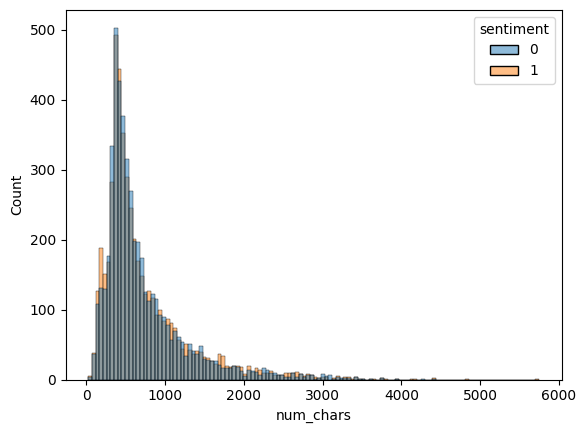

In [63]:
sns.histplot(x="num_chars",data=df,hue="sentiment")

<Axes: xlabel='num_words', ylabel='Count'>

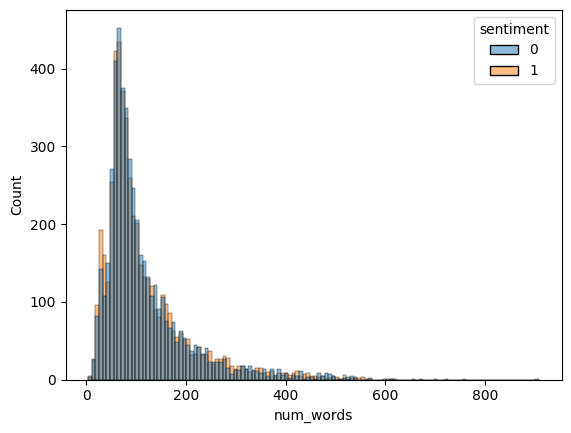

In [64]:
sns.histplot(x="num_words",data=df,hue="sentiment")

Text(0.5, 1.0, 'Sentiment polarity Distribution')

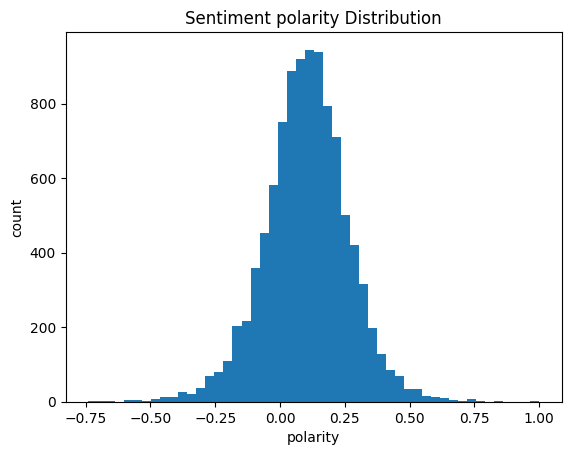

In [65]:
df["polarity"].plot(kind="hist",bins=50)
plt.xlabel("polarity")
plt.ylabel("count")
plt.title("Sentiment polarity Distribution")

In [84]:
from wordcloud import WordCloud

In [85]:
wc = WordCloud(width = 500,height=500,min_font_size=10)

In [86]:
positive_wc = wc.generate(df[df["sentiment"] == 1]["review"].str.cat(sep=" "))

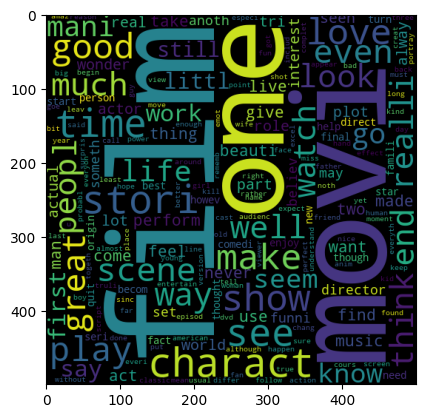

In [87]:
plt.imshow(positive_wc)

In [88]:
negative_wc = wc.generate(df[df["sentiment"] == 0]["review"].str.cat(sep=" "))

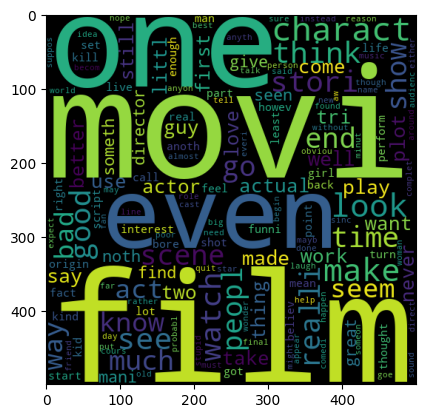

In [89]:
plt.imshow(negative_wc)

### Text Vectorization

### Count Vectorizer

In [66]:
X = df["review"]
y = df["sentiment"]

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [68]:
cv = CountVectorizer(max_features=5000)
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

In [69]:
svc = SVC(kernel="sigmoid",gamma=1)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver="liblinear",penalty="l1")
rfc = RandomForestClassifier(n_estimators=50,random_state=2)
ad = AdaBoostClassifier(n_estimators=50,random_state=2)
bc = BaggingClassifier(n_estimators=50,random_state=2)
gb = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = xgboost.XGBClassifier(n_estimators=50,random_state=2)
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

In [70]:
clfs = {
    "SVC":svc,
    "KNN":knc,
    "ADA":ad,
    'GB':gb,
    "BC":bc,
    "XGB":xgb,
    "RFC":rfc,
    "LRC":lrc,
    "DTC":dtc,
    "GNB":gnb,
    "BNB":bnb,
    "MNB":mnb
}

In [71]:
def train_classifier(clf):
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    f1score = f1_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    return accuracy,f1score,report

In [72]:
accuracy,f1,report = train_classifier(gnb)
print(accuracy)
print(report)
print(f1)

0.7123561780890445
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       999
           1       0.78      0.60      0.68      1000

    accuracy                           0.71      1999
   macro avg       0.72      0.71      0.71      1999
weighted avg       0.72      0.71      0.71      1999

0.6753246753246753


In [73]:
accuracy_scores = []
score = []

for name,clf in clfs.items():
    current_acc,current_f1,current_report = train_classifier(clf)
    
    print("Name: ",name)
    print("Accuracy: ",current_acc)
    print("F1: ",current_f1)
    print("Report:\n",current_report)
    print("******************")
    
    accuracy_scores.append(current_acc)
    score.append(current_f1)
    

Name:  SVC
Accuracy:  0.5342671335667833
F1:  0.5356608478802993
Report:
               precision    recall  f1-score   support

           0       0.53      0.53      0.53       999
           1       0.53      0.54      0.54      1000

    accuracy                           0.53      1999
   macro avg       0.53      0.53      0.53      1999
weighted avg       0.53      0.53      0.53      1999

******************
Name:  KNN
Accuracy:  0.6048024012006002
F1:  0.6612349914236707
Report:
               precision    recall  f1-score   support

           0       0.66      0.44      0.53       999
           1       0.58      0.77      0.66      1000

    accuracy                           0.60      1999
   macro avg       0.62      0.60      0.59      1999
weighted avg       0.62      0.60      0.59      1999

******************
Name:  ADA
Accuracy:  0.7888944472236118
F1:  0.7963320463320464
Report:
               precision    recall  f1-score   support

           0       0.81      0.

In [74]:
performance_df = pd.DataFrame({
    "Algorithm":clfs.keys(),
    "Accuracy":accuracy_scores,
    "F1 score":score
})

In [75]:
performance_df

,Algorithm,Accuracy,F1 score
0,SVC,0.534267,0.535661
1,KNN,0.604802,0.661235
2,ADA,0.788894,0.796332
3,GB,0.772886,0.787054
4,BC,0.775888,0.777336
5,XGB,0.809405,0.814056
6,RFC,0.811906,0.807574
7,LRC,0.848924,0.848849
8,DTC,0.689845,0.735495
9,GNB,0.712356,0.675325


<BarContainer object of 12 artists>

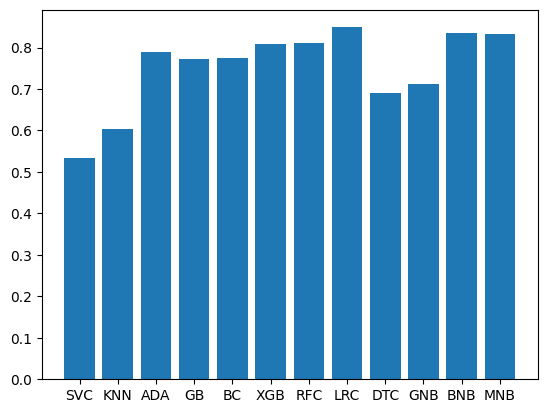

In [93]:
plt.bar(performance_df["Algorithm"],performance_df["Accuracy"])

In [76]:
performance_df.sort_values(by="Accuracy",ascending=False)

,Algorithm,Accuracy,F1 score
7,LRC,0.848924,0.848849
10,BNB,0.835418,0.835910
11,MNB,0.833917,0.832323
6,RFC,0.811906,0.807574
5,XGB,0.809405,0.814056
2,ADA,0.788894,0.796332
4,BC,0.775888,0.777336
3,GB,0.772886,0.787054
9,GNB,0.712356,0.675325
8,DTC,0.689845,0.735495


In [77]:
clf_b = BernoulliNB().fit(X_train,y_train)
clf_mnb = MultinomialNB().fit(X_train,y_train)
clf_gnb = GaussianNB().fit(X_train,y_train)
clf_rfc = RandomForestClassifier().fit(X_train,y_train)
clf_xgb = xgboost.XGBClassifier().fit(X_train,y_train)
clf_ada = AdaBoostClassifier().fit(X_train,y_train)
clf_bc = BaggingClassifier().fit(X_train,y_train)
clf_gb = GradientBoostingClassifier().fit(X_train,y_train)
clf_dt = DecisionTreeClassifier().fit(X_train,y_train)
clf_knn = KNeighborsClassifier().fit(X_train,y_train)

In [79]:
import pickle

for i,j in enumerate([clf_b,clf_mnb,clf_gnb,clf_rfc,clf_xgb,clf_ada,clf_bc,clf_gb,clf_dt,clf_knn]):
    with open(f"model_cv_{i}.pkl", "wb") as f:
        pickle.dump(j, f)

In [100]:
with open(f"cv.pkl", "wb") as f:
        pickle.dump(cv,f)

### TFIDF Vectorizer

In [80]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [81]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [82]:
accuracy,f1,report = train_classifier(gnb)
print(accuracy)
print(report)
print(f1)

0.6348174087043522
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       999
           1       0.64      0.61      0.63      1000

    accuracy                           0.63      1999
   macro avg       0.64      0.63      0.63      1999
weighted avg       0.64      0.63      0.63      1999

0.6252566735112937


In [83]:
accuracy_scores = []
score = []

for name,clf in clfs.items():
    current_acc,current_f1,current_report = train_classifier(clf)
    
    print("Name: ",name)
    print("Accuracy: ",current_acc)
    print("F1: ",current_f1)
    print("Report:\n",current_report)
    print("******************")
    
    accuracy_scores.append(current_acc)
    score.append(current_f1)
    

Name:  SVC
Accuracy:  0.8659329664832416
F1:  0.8681102362204726
Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86       999
           1       0.85      0.88      0.87      1000

    accuracy                           0.87      1999
   macro avg       0.87      0.87      0.87      1999
weighted avg       0.87      0.87      0.87      1999

******************
Name:  KNN
Accuracy:  0.7258629314657329
F1:  0.743685687558466
Report:
               precision    recall  f1-score   support

           0       0.76      0.66      0.71       999
           1       0.70      0.80      0.74      1000

    accuracy                           0.73      1999
   macro avg       0.73      0.73      0.72      1999
weighted avg       0.73      0.73      0.72      1999

******************



KeyboardInterrupt



In [ ]:
performance_df = pd.DataFrame({
    "Algorithm":clfs.keys(),
    "Accuracy":accuracy_scores,
    "F1 score":score
})

In [ ]:
performance_df.sort_values(by="Accuracy",ascending=False)

In [ ]:
clf_b = BernoulliNB().fit(X_train,y_train)
clf_mnb = MultinomialNB().fit(X_train,y_train)
clf_gnb = GaussianNB().fit(X_train,y_train)
clf_rfc = RandomForestClassifier().fit(X_train,y_train)
clf_xgb = xgboost.XGBClassifier().fit(X_train,y_train)
clf_ada = AdaBoostClassifier().fit(X_train,y_train)
clf_bc = BaggingClassifier().fit(X_train,y_train)
clf_gb = GradientBoostingClassifier().fit(X_train,y_train)
clf_dt = DecisionTreeClassifier().fit(X_train,y_train)
clf_knn = KNeighborsClassifier().fit(X_train,y_train)

In [ ]:
import pickle

for i,j in enumerate([clf_b,clf_mnb,clf_gnb,clf_rfc,clf_xgb,clf_ada,clf_bc,clf_gb,clf_dt,clf_knn]):
    with open(f"model_tv_{i}.pkl", "wb") as f:
        pickle.dump(j, f)

In [ ]:
clf = SVC(kernel="sigmoid",gamma=1)
clf.fit(X_train,y_train)

In [ ]:
text = remove_punctuation("It was a very Amazing movie. I went and watched it twice")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("One of the bad movies. Climax was the worst one")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("Climax was the worst one")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("One of the best movies of all time")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("It was not a very good film.  I was bored a lot of time")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("I was shocked")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("Still manages to astound after 20 years of repeat viewings")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("A brilliant postmodern film noir that is grim, intelligent and disturbing")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("An out and out classic.")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("A dark and disturbing masterpiece.")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [96]:
text = remove_punctuation("David Fincher Strikes Again, With An Unwavering Thriller That Strikes Straight To The Heart")
text = remove_stopwords(text)
text = stemming(text)
text

'david fincher strike again with An unwav thriller that strike straight To the heart'

In [ ]:
text = remove_punctuation("Besides a soulful score by Ajay Atul, this adaptation of Ramayana is a baffling and collosal dissapointment.")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("Pathetic Ramayan parody")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [ ]:
text = remove_punctuation("Tiresome Commercialized Ramayan")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

In [94]:
df.to_csv("Total_10000_records.csv",index=False)

In [98]:
def processing_data(text):
    
    text = text.lower()
    
    for key in contractions.keys():
            value = contractions[key]
            text = text.replace(key,value)
            
    text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
    
    text = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    text = word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y.copy()
    y.clear()

    for i in text:
        if (i not in stopwords.words("english")) and (i not in string.punctuation ):
            y.append(i)

    text = y.copy()
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)


In [99]:
processing_data("David Fincher Strikes Again, With An Unwavering Thriller That Strikes Straight To The Heart")

'david fincher strike unwav thriller strike straight heart'